# Main Subroutines

In [ ]:
#Continue from
#1. Look for ways to run jupyter cell from another cell
#2. Implement Section Large Sphere Model

#Naming conventions
#unod represents unod3d and unod2d does not exist due to one node indexing system; always a 1d vector
#u3d_edge and u3d_elem represent uele3d_edge and uele3d_elem in short; each has four columns (first as field; rest as gradient vector)

#Unsolved
#1.distance scaling factor does not work for coupled problems
#2.set_first_kind_bc needs to be updated to accomendate more rows in K
#3.update with_first_kind_bc with the size of faces/edges in 3D implementation
#4.declare numpy type explicitly for function input/output variables
#5.bugs in set_first_kind_bc* need to be fixed (refer to np.where in set_inactive_nodes*)
#6.bugs in assemble_Ks2d and 3d need to be fixed; similar ways to set_first_kind_bc2d in fix bugs section

This spectral induced polarization (SIP) modeling code is dedicated to solve PDEs and the sytems of PDEs of the general type
<center>
    $\nabla\cdot(-c\nabla u-\alpha u+\gamma)+\beta\cdot\nabla u+\alpha u=f$</center>
with the general boundary conditions
<center>
    $-\mathbf n(\cdot\nabla u-\alpha u+\gamma)=g-qu \;\;\;\text{and}$</center>
<center>
    $u=s,$</center>
where $u$ denotes the dependent variable and $\mathbf n$ the inward-pointing unit normal vector.
    

    

## Basic functions

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt

import copy,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]
kF=96485.0 #Faraday's constant [As/mol]

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    mesh['nodes']=mesh['nodes']*dist_factor
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)

    materials['cx']=materials['cx']/1.0
    materials['cy']=materials['cy']/1.0
    materials['cz']=materials['cz']/1.0

    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor

    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor

    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor

    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/1.0
    materials['anod']=materials['anod']/dist_factor**2
    materials['fnod']=materials['fnod']/dist_factor**2

    return materials

def compute_mids2d_edge(nodes,edges,dist_factor,local):
    #compute middle point of face element (efficiency to be improved)
    nedge=len(edges[:,0])
    midpoints=np.zeros((nedge,4))
    for i in range(0,nedge):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[edges[i,:],j])/2.0
        
        R=rotate_line(nodes[edges[i,:],:])
        midpoints[i,2:]=R.dot(midpoints[i,:2].T).T
    
    if local:
        midpoints=midpoints[:,2:]
    else:
        midpoints=midpoints[:,:2]

    return midpoints*dist_factor

def compute_mids2d_elem(nodes,elements,dist_factor):
    #compute middle point of 2D element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,2))
    for i in range(0,nelem):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/3.0

    return midpoints*dist_factor

def compute_mids3d_face(nodes,faces,dist_factor,local):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,6))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3.0
        
        R=rotate_triangle(nodes[faces[i,:],:])
        midpoints[i,3:]=R.dot(midpoints[i,:3].T).T
        
    if local:
        midpoints=midpoints[:,3:]
    else:
        midpoints=midpoints[:,:3]

    return midpoints*dist_factor

def compute_mids3d_elem(nodes,elements,dist_factor):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/4.0

    return midpoints*dist_factor

def grad2d_edge(nodes,edges,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nedge=len(edges)
    u2d=np.zeros((nedge,5),dtype=complex)
    Je=np.ones((2,2))
    for i in range(nedge): #consider parallelization
        nind=edges[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/2.0
        yr=sum(nodes_new[:,1])/2.0
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        u2d[i,1:3]=[dudx,0]
        u2d[i,3:5]=np.linalg.inv(R).dot([dudx,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u2d=u2d[:,[0,1,2]]
    else:
        u2d=u2d[:,[0,3,4]]

    return u2d*dist_factor

def grad2d_elem(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u2d=np.zeros((nelem,3),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes[nind,0])/3.0
        yr=sum(nodes[nind,1])/3.0
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
        u2d[i,1]=sum(unod[nind]*invJe[:,1])
        u2d[i,2]=sum(unod[nind]*invJe[:,2])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u2d*dist_factor

def grad3d_face(nodes,faces,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nface=len(faces)
    u3d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3.0
        yr=sum(nodes_new[:,1])/3.0
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u3d[i,1:4]=[dudx,dudy,0]
        u3d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u3d=u3d[:,[0,1,2,3]]
    else:
        u3d=u3d[:,[0,4,5,6]]

    return u3d*dist_factor

def grad3d_elem(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes[nind,0])/4.0
        yr=sum(nodes[nind,1])/4.0
        zr=sum(nodes[nind,2])/4.0
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_line(nodes):
    #rotate 2D line along vector n to x
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]

    n=np.array([xnod[1]-xnod[0],ynod[1]-ynod[0],0])
    length=np.linalg.norm(n)

    n=n/np.linalg.norm(n)
    x=np.array([1,0,0])
    k=np.cross(n,x)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,x)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R[:-1,:-1]

def rotate_triangle(nodes):
    #rotate 3D triangle with normal vector n to z
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2

    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    sol=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return sol

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    #diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    #diag[cols,cols]=0
    return M.dot(diag)

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    return rho,theta,phi

def spherical2cartesian(rho,theta,phi):
    x=rho*np.cos(phi)*np.sin(theta)
    y=rho*np.sin(phi)*np.sin(theta)
    z=rho*np.cos(theta)
    return x,y,z

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        nind=np.argmin(dist2)
        output[i,6]=np.real(unod[nind])
        output[i,7]=np.imag(unod[nind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def reshape_unod(unod_in,coupled,nrep=1):
    #default numpy.reshape order is column major
    if coupled:
        nnode=int(len(unod_in)/nrep/2)
        unod=np.zeros((nnode,nrep*2),dtype=complex)
        unod[:,:nrep]=np.reshape(unod_in[:nnode*nrep],(nnode,nrep))
        unod[:,nrep:]=np.reshape(unod_in[nnode*nrep:],(nnode,nrep))
    else:
        nnode=int(len(unod_in)/nrep)
        unod=np.zeros((nnode,nrep),dtype=complex)
        unod[:,:nrep]=np.reshape(unod_in,(nnode,nrep))
    return unod

if __name__=='__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## Kernel functions 2D

In [2]:
def assemble_Ke1d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d2d(xnod,gamma_x=gamma_x[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d2d(xnod,gamma_x,nrep=1):
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1])*length*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area
        #be is a placeholder; unused

    #don't forget return -Ke instead of Ke
    return -Ke,be

def assemble_Ks2d1d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d1d(xnod,ynod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d1d(xnod,ynod,gs,nrep=1):
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*length*(1+delta_ij)/6.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*length*(1+delta_ij)/6.0
        #bs[i]=gs[kk]*length/2.0
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def assemble_Ke1d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern,:]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    cx=np.reshape(materials['cx'][in_stern],(nedge_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nedge_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nedge_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nedge_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d_edge(xnod,cx=cx[i],alpha_x=alpha_x[i],beta_x=beta_x[i],
            gamma_x=gamma_x[i],a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d_edge(xnod,cx,alpha_x,beta_x,gamma_x,a,f,nrep=1):
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+
                     a[kk,ll]*(1+delta)/6.0+
                     (alpha_x[kk,ll]*invJe[ii,1])/2.0+
                     (beta_x[kk,ll]*invJe[jj,1])/2.0)*length
        be[i]=(gamma_x[kk]*invJe[ii,1]+f[kk]/2.0)*length

    return Ke,be

def assemble_Ke2d_elem(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_active=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_active=len(elements_active)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_active,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_active,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_active,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_active,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_active,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_active,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_active,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_active,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_active*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_active):
        nind=elements_active[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ke,be=build_Ke2d_elem(xnod,ynod,cx=cx[i],cy=cy[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],
            beta_x=beta_x[i],beta_y=beta_y[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],
            a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d_elem(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,beta_y,
        gamma_x,gamma_y,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0+
                     anod[jj,kk,ll]*(1+delta)/12.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

        for jj in range(3):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*area*(1+delta)/12.0

    return Ke,be

def assemble_Ks2d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=np.reshape(mesh['with_third_kind_bc'],(-1,nrep))
    with_third_kind_bc=np.any(with_third_kind_bc,axis=1) #temporary solution

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nedge_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d_edge(xnod,ynod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d_edge(xnod,ynod,gs,qs,nrep=1):
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*length*(1+delta)/6.0
        bs[i]=gs[kk]*length/2.0

    return Ks,bs

def set_first_kind_bc2d_node(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    on_first_kind_bc=mesh['on_first_kind_bc']
    nind_bc=np.where(on_first_kind_bc)[0]
    nind_in=np.where(~on_first_kind_bc)[0]
    nodes_bc=nodes[nind_bc,:]

    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][nind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_first_kind_bc2d_edge(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    edges=mesh['edges']
    with_first_kind_bc=np.reshape(mesh['with_first_kind_bc'],(-1,nrep))
    nnode=len(nodes)
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    
    for irep in range(nrep):
        nind_bc=np.unique(edges[with_first_kind_bc[:,irep],:].flatten(order='C'))
        mask_in=np.ones(nnode,dtype=bool)
        mask_in[nind_bc]=False
        nind_in=np.where(mask_in)[0]
        nodes_bc=nodes[nind_bc,:]

        nnode_bc=len(nodes_bc)
        snod=np.reshape(materials['snod'][nind_bc],(nnode_bc,nrep))[:,irep]
        REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

        for i in nind_in:
            rows=REP[i,:].flatten(order='C')+offset[0]
            cols=REP[nind_bc,irep].flatten(order='C')+offset[1]
            #may need to expand cols by including the coupled rows in K and b
            for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
                b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

        rows=REP[nind_bc,irep].flatten(order='C')+offset[0]
        cols=REP[nind_bc,irep].flatten(order='C')+offset[1]
        #reduce rows and cols by checking True or False in with_first_kind_bc
        M=csr_matrix(K.shape).tolil()
        M[rows,cols]=1.0
        K=zero_rows(K,rows)
        K=zero_cols(K,cols)
        K=K+M
        b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_inactive_nodes2d_edge(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    edges=mesh['edges']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(edges[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d_elem(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_active=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_active]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

if __name__=='__main__':
    print('Done')

Done


## Kernel functions 3D

In [ ]:
def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area
        #be is a placeholder; unused

    #don't forget return -Ke instead of Ke
    return -Ke,be

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12.0
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def assemble_Ke2d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern,:]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
    cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d_face(xnod,ynod,cx=cx[i],cy=cy[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],
            beta_x=beta_x[i],beta_y=beta_y[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],
            a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d_face(xnod,ynod,cx,cy,alpha_x,alpha_y,
        beta_x,beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return Ke,be

def assemble_Ke3d_elem(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d_elem(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
            alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
            beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
            gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
            a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke3d_elem(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
        beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6.0

    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4.0+
                     anod[jj,kk,ll]*(1+delta)/20.0)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4.0)*vol

        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20

    return Ke,be

def assemble_Ks3d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d_face(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks3d_face(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12.0
        bs[i]=gs[kk]*area/3.0

    return Ks,bs

def set_first_kind_bc3d_node(): #placeholder
    
    return

def set_first_kind_bc3d_face(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #to be modified
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    faces=mesh['faces']
    with_first_kind_bc=mesh['with_first_kind_bc'] #this will be changed from node index to face index

    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d_face(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d_elem(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

if __name__=='__main__':
    print('Done')

## Analytical solutions

In [ ]:
def anso_slab(z,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in cartesian coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT INTERFACE IS:',zeta)
    else:
        print('POTENTIAL AT INTERFACE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta*debye_len/perm0/rel_perm
        
    u=np.zeros((len(z),4))
    mask=z>=a
    u[mask,0]=zeta*np.exp(-z/debye_len)
    u[~mask,0]=zeta
    return u

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm

    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

if __name__=='__main__':
    print('Done')

## External functions

In [ ]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

if __name__=='__main__':
    print('Done')

## List of variables

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos module

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos function

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos str int float dict

In [ ]:
#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
%whos ndarray

# Templates

# Sphere Model

## Radial discretization <a id="3.1"></a>

# Slab Model

## Radial discretization <a id="4.1"></a>

DEBYE LENGTH IS: 9.63e+00 nm


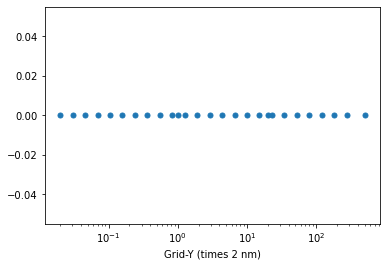

Done


In [3]:
def discretize_grid():
    #debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    debye_len=np.sqrt(perm0*80*kB*293/2/1**2/echarge**2/kA/1)
    print('DEBYE LENGTH IS: %.2e nm'%(debye_len*1e9))
    
    #obtain fine grid next to the solid-liquid interface
    #use 16 points between 0.02*debye_len and 10*debye_len
    #reduce debye_len if thin water film presents
    debye_len=min(debye_len,2e-9)
    rho=np.logspace(np.log10(0.02),1,16)*debye_len
    dr=np.diff(np.log10(rho/debye_len))[0]
    
    #use the logarithmic interval above to discretize the entire space
    #which extends to 1000 nm or 1e-6 m in Y for this slab example
    n=2
    while 1:
        rho=np.power(10,np.arange(np.log10(0.02),1+dr*n,dr))*debye_len
        if rho[-1]<1e-6:
            n=n+1
        else:
            break
            
    #adjust the starting and ending points in the discretization
    rho=np.r_[0,rho[:-2],1e-6]
    
    #insert 2e-9 into rho for the thin water film
    mask=rho<2e-9
    rho=np.r_[rho[mask],2e-9,rho[~mask]]
    
    #insert 40e-9 into rho for the top of the equipotential surface
    mask=rho<40e-9
    rho=np.r_[rho[mask],40e-9,rho[~mask]]
    
    #display and check the discretization
    fig,ax=plt.subplots()
    mask=rho>0
    ax.plot(rho[mask]/debye_len,np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlabel('Grid-Y (times %d nm)'%(debye_len*1e9))
    #ax.set_xlim(0.01,20)
    plt.show()

    return rho

if __name__=='__main__':
    rho=discretize_grid()
    #print(rho)
    print('Done')

## Survey files <a id="4.2"></a>

## Mesh generation <a id="4.3"></a>

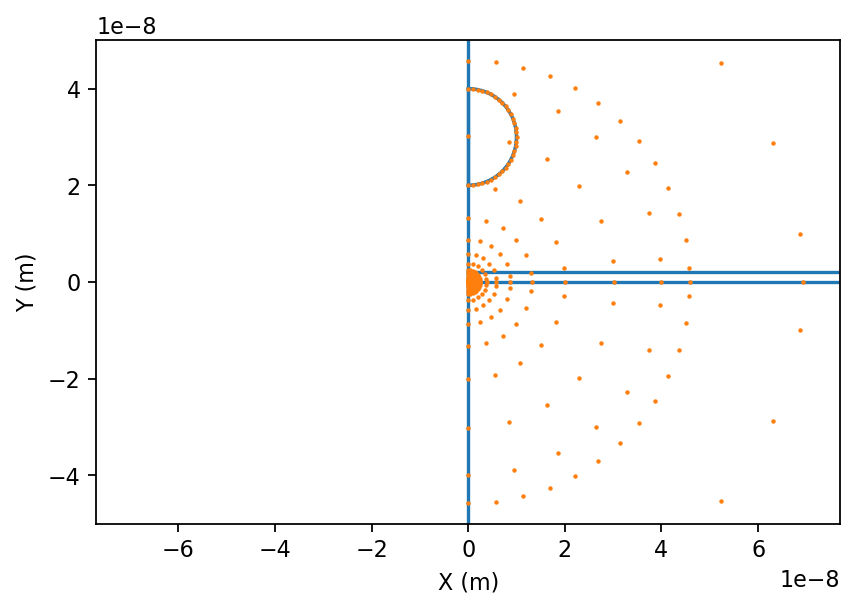

Opening slab_2d.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  1
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  13

Writing slab_2d.1.node.
Writing slab_2d.1.ele.
Writing slab_2d.1.poly.
Writing slab_2d.1.edge.
Writing slab_2d.1.neigh.

Output milliseconds:  23
Total running milliseconds:  39

Statistics:

  Input vertices: 400
  Input segments: 120
  Input holes: 1

  Mesh vertices: 4331
  Mesh triangles: 8411
  Mesh edges: 12741
  Mesh exterior boundary edges: 249
  Mesh interior boundary edges: 678
  Mesh subsegments (constrained edges): 927

Done


In [4]:
import subprocess

def generate_mesh():
    #define the outer boundary points at four corners
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    x = [0,1e-6,1e-6,0]
    y = [-1e-6,-1e-6,1e-6,1e-6]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the outer boundary points along the axis of symmetry (x of 0)
    x = np.zeros((2*len(rho)-3))
    y = np.r_[-np.flipud(rho[1:-1]),rho[:-1]]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the outer boundary points on the left side of the water (x of 1e-6)
    x = [1e-6,1e-6]
    y = [0,2e-9]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the inner control points at the solid-water interface (y of 0)
    x = np.array(rho[1:-1])
    y = np.zeros(len(rho)-2)
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
        
    #define the inner control points along the equipotential surface
    #centered at (0,30e-9) with radius 10e-9 in the air
    nA = 32
    ns = nA+1-2
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA-np.pi/2 #half the circle
    x = 10e-9*np.cos(phi)+0.0
    y = 10e-9*np.sin(phi)+30e-9
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    #define the segments on the bottom of ourter boundary (y of -1e-6)
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    x = [0,1e-6]
    y = [-1e-6,-1e-6]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,1]] #edge flag of 1
    
    #define the segments on the left of the outer boundary (x of 1e-6)
    x = [1e-6,1e-6,1e6,1e6]
    y = [-1e-6,0,2e-9,1e6]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,2]] #edge flag of 2
    
    #define the segments on the top of the outer boundary (y of 1e-6)
    x = [0,1e-6]
    y = [1e-6,1e-6]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,3]] #edge flag of 3
    
    #define the segmesnts on the right side of the outer boundary (x of 0)
    x = np.zeros((2*len(rho)-1))
    y = np.r_[-np.flipud(rho[1:]),rho[:]]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,4]] #edge flag of 4
        
    #define the segments at the solid-water interface (y of 0)
    x = np.array(rho)
    y = np.zeros((len(rho)))
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,5]] #edge flag of 5
        
    #define the segments at the water-air interface (y of 2e-9)
    x = [0,1e-6]
    y = [2e-9,2e-9]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,6]] #edge flag of 6
    
    #define the segments along the equipotential surface
    #centered at (0,30e-9) with radius 10e-9 in the air
    nA = 32
    ns = nA+1-2
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA-np.pi/2 #half the circle
    x = np.r_[0,10e-9*np.cos(phi)+0.0,0,0]
    y = np.r_[20e-9,10e-9*np.sin(phi)+30e-9,40e-9,20e-9]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,7]] #edge flag of 7

    #define refined control points inside the domain
    for i in range(1,len(rho)-1):
        nA = np.ceil(np.pi/(rho[i]-rho[i-1])*rho[i])//2*2+1 #round to the nearest odd
        ns = nA+1-2
        dA = np.pi/nA
        phi = np.arange(1,ns+1)*dA-np.pi/2 #half the circle
        x = rho[i]*np.cos(phi)
        y = rho[i]*np.sin(phi)
        #x = [rho[i],rho[i]]
        #y = [rho[i],-rho[i]]
        cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    fig,ax=plt.subplots(dpi=160)
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    ax.plot(x.T,y.T,'-',color='tab:blue')
    ax.plot(cpts[:,0],cpts[:,1],'.',markersize=2,color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
    ax.set_xlim(-50e-9,50e-9)
    ax.set_ylim(-50e-9,50e-9)
#     ax.set_xlim(-1e-9,1e-9)
#     ax.set_ylim(-1e-9,1e-9)
    plt.show()
    
    #build the poly file
    f1 = open('slab_2d.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1    
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e9,cpts[i,1]*1e9,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n\n')

    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1

    #holes
    f1.write('\n\n1\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1\n'.format(1.0,30.0))
    f1.write('\n\n')

    #area constraints for each of 4 zones
    f1.write('3\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(10.0,-1.0,1000))
    f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(10.0,1.0,1000))
    f1.write('3 {0:12.6F} {1:12.6F} 3 {2:12.6F}\n'.format(10.0,100.0,1000))

    f1.write('# triangle -pnq30Aae slab_2d.poly \n')
    f1.close()

    return cpts,segs

if __name__=='__main__':
    cpts,segs=generate_mesh()
    process=subprocess.Popen(['triangle -pnq30Aae slab_2d.poly'],shell=True)
    process.wait()

    print('Done')

## Mesh visualization <a id="4.4"></a>

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge
THE NUMBER OF NODES IS: 4333
THE NUMBER OF ELEMENTS IS: 8411
THE NUMBER OF EDGES IS: 12741
THE NUMBER OF ZONES IS: 3
node_flags [0 1 2 3 4 5 6 7]
zones [1 2 3]
edge_flags [0 1 2 3 4 5 6 7]



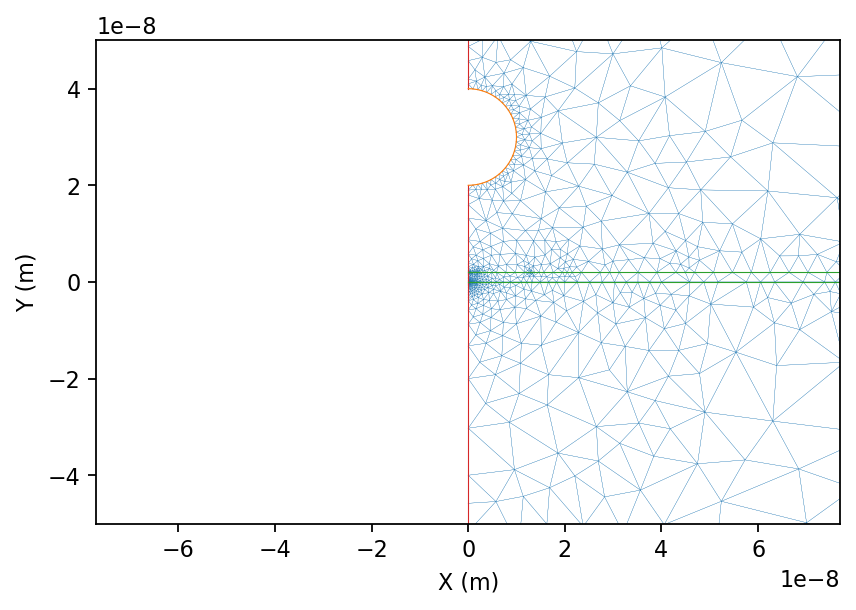

Done


In [5]:
def display_mesh():
    #modify user inputs below
    mesh_prefix='slab_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-9
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('THE NUMBER OF ZONES IS: %d'%len(np.unique(zones)))
    print('node_flags',np.unique(node_flags))
    print('zones',np.unique(zones))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    fig,ax=plt.subplots(dpi=160)
    mask=zones>=1 #select zones to display
    x=nodes[elements[:,[0,1,2,0]],0]
    y=nodes[elements[:,[0,1,2,0]],1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.1,color='tab:blue')    
    
    mask=(edge_flags>=1)&(edge_flags<=3)
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:orange')
    
    mask=edge_flags==4
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:red')
    
    mask=(edge_flags==5)|(edge_flags==6)
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:green')
    
    mask=edge_flags==7
    x=nodes[edges,0]
    y=nodes[edges,1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:orange')

#     mask=node_flags==1
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:green')
#     mask=node_flags==2
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:red')
#     mask=node_flags==3
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:orange')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
    ax.set_xlim(-50e-9,50e-9)
    ax.set_ylim(-50e-9,50e-9)
#     ax.set_xlim(-10e-9,10e-9)
#     ax.set_ylim(-10e-9,10e-9)
    return fig,ax

if __name__=='__main__':
    fig,ax=display_mesh()
    plt.show()
    print('Done')

## Mesh properties <a id="4.5"></a>

In [16]:
def set_mesh():
    #modify user inputs below
    mesh_prefix='slab_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1

    #scale nodes from meter to micro-meter
    nodes=nodes*1e-9

    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('node_flags',np.unique(node_flags))
    print('zones',np.unique(zones))
    print('edge_flags',np.unique(edge_flags))
    print('')

    #define computational elements and boundaries
    in_active_zones=zones>=1 #True for elements used in computation
    
    #define computational edges for first and third kind b.c.
    with_first_kind_bc=(edge_flags>=1)&(edge_flags<=3) #True for edges on first kind b.c.
    with_first_kind_bc=with_first_kind_bc|(edge_flags==7)
    with_third_kind_bc=edge_flags==5 #True for edges on third kind b.c.
    
    #define computational nodes for first kind b.c.
    nind_bc=np.argmin((nodes[:,0]-1e-6)**2+(nodes[:,1]-0.0)**2)
    on_first_kind_bc=np.zeros(nnode,dtype=bool) #True for nodes on first kind b.c.
    on_first_kind_bc[nind_bc]=True

    #define electrolyte,solid,stern layer
    in_air=zones==3
    in_electrolyte=zones==2
    in_solid=zones==1
    in_stern=edge_flags==5
    
    #more properties
    with_equipotential_bc=edge_flags==7 #equipotential surface

    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_active))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES IN STERN LAYER IS:',len(nind_stern))
    print('THE NUMBER OF EDGES IN STERN LAYER IS:',np.count_nonzero(in_stern))
    print('')
        
    mesh={'elements':elements,'nodes':nodes,'edges':edges,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'on_first_kind_bc':on_first_kind_bc,
          'in_air':in_air,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'with_equipotential_bc':with_equipotential_bc}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-11 #mobility in Stern layer [m^2/(Vs)]
    sigma_solid=-0.01 #surface charge density in solid [C/m^2]
    
    temp_K=293 #room/ambient temperature [K]
    cinf=1.0 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR SOLID IS:',sigma_solid)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_solid':sigma_solid,'debye_len':debye_len,
             'sigma_electrolyte':None,'sigma_stern':None,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge
THE NUMBER OF NODES IS: 4333
THE NUMBER OF ELEMENTS IS: 8411
THE NUMBER OF EDGES IS: 12741
node_flags [0 1 2 3 4 5 6 7]
zones [1 2 3]
edge_flags [0 1 2 3 4 5 6 7]

THE NUMBER OF ACTIVE NODES IS: 4331
THE NUMBER OF ACTIVE ELEMENTS IS: 8411
THE NUMBER OF NODES IN STERN LAYER IS: 343
THE NUMBER OF EDGES IN STERN LAYER IS: 342

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.63e-09 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+08

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 1.2628995006242197e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.2628995006242196e-12
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-11
SURFACE CHARGE DENSITY FOR SOLID IS: -0.01
TEMPERATURE IS: 293
ION COCENTRATION AT INFINITY IS: 1.0
ION VALENCE IS: 1

Done


## Perturbed solution <a id="4.6"></a>

In [18]:
import os

def set_materials1d(mesh,physics,u1d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nedge,dtype=complex)
    alpha_x=np.zeros(nedge,dtype=complex)
    alpha_y=np.zeros(nedge,dtype=complex)
    alpha_z=np.zeros(nedge,dtype=complex)

    beta_x=np.zeros(nedge,dtype=complex)
    beta_y=np.zeros(nedge,dtype=complex)
    beta_z=np.zeros(nedge,dtype=complex)

    gamma_x=np.zeros(nedge,dtype=complex)
    gamma_y=np.zeros(nedge,dtype=complex)
    gamma_z=np.zeros(nedge,dtype=complex)

    a=np.zeros(nedge,dtype=complex)
    f=np.zeros(nedge,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet
    anod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet
    fnod=np.zeros(nnode,dtype=complex) #placeholder; not implemented yet

    nodes=mesh['nodes']
    edges=mesh['edges']
    #mids2d_edge local and global are the same in this example
    #need to verify from the initial coordinate conversion formula
    #to make sure if local or global mids2d_edge should be used
    mids2d_edge=compute_mids2d_edge(nodes,edges,dist_factor=1.0,local=False)
    
    #shall below be mids2d_edge or mids1d_edge; need to be verified
    c[in_stern]=physics['diffusion_stern']*mids2d_edge[in_stern,0]
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']*mids2d_edge[in_stern,0] #coupled coefficient
    a[in_stern]=1j*freq*mids2d_edge[in_stern,0]
    
    on_first_kind_bc=mesh['on_first_kind_bc']
    snod[on_first_kind_bc]=0.0
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nedge,dtype=complex)
    qs=np.zeros(nedge,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']
    mids2d_edge=compute_mids2d_edge(nodes,edges,dist_factor=1.0,local=False)
    mids2d_elem=compute_mids2d_elem(nodes,elements,dist_factor=1.0)
    
    c[in_air]=perm0*mids2d_elem[in_air,0]
    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']*mids2d_elem[in_electrolyte,0]
    c[in_solid]=perm0*physics['rel_perm_solid']*mids2d_elem[in_solid,0]
    gs[in_stern]=1.0*mids2d_edge[in_stern,0] #coupled coefficient; sign to be verified
    
    with_equipotential_bc=mesh['with_equipotential_bc']
    nind_bc=np.unique(edges[with_equipotential_bc,:].flatten(order='C'))
    snod[nind_bc]=10.0 #Volts
        
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    mats2d_zero_gs=copy.deepcopy(materials2d)
    mats2d_zero_gs['gs'][:]=0

    mats1d_zero_gamma=copy.deepcopy(materials1d)
    mats1d_zero_gamma['gamma_x'][:]=0
    mats1d_zero_gamma['gamma_y'][:]=0

    K=csr_matrix((nnode*2,nnode*2),dtype=complex)
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke2d_elem(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 element
    K,b=assemble_Ks2d_edge(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 edge
    K,b=assemble_Ke1d_edge(mesh,mats1d_zero_gamma,K,b,offset=(nnode,nnode),nrep=1) #K22 element

    K,b=assemble_Ks2d1d(mesh,materials2d,K,b,offset=(0,nnode),nrep=1) #coupled term of K12
    K,b=assemble_Ke1d2d(mesh,materials1d,K,b,offset=(nnode,0),nrep=1) #coupled term of K12

    K,b=set_first_kind_bc2d_edge(mesh,materials2d,K,b,offset=(0,0),nrep=1) #K11 1st kind b.c.
    K,b=set_first_kind_bc2d_node(mesh,materials1d,K,b,offset=(nnode,nnode),nrep=1) #K22 1st kind b.c.
    K,b=set_inactive_nodes2d_elem(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d_edge(mesh,K,b,offset=(nnode,nnode),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    savedir='/shared/zhuy359/sip/slab'
    srvfile='not_exit.srv'
    dist_factor=1.0 #not tested yet
    #freqs=[0]
    freqs=np.logspace(-2,7,19)
    ratio=1.0
    
    #do not modify anything below this line
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])
        
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    
    for i in range(len(freqs)):
        print('==================== Frequency %d/%d'%(i+1,len(freqs)),' ====================')
        u1d=np.zeros((len(mesh['edges']),3))
        u2d=np.zeros((len(mesh['elements']),3))
        materials1d=set_materials1d(mesh,physics,u1d,freq=freqs[i],case=5)
        materials2d=set_materials2d(mesh,physics,u2d,freq=freqs[i],case=5)
        mesh_scale=scale_mesh(mesh,dist_factor)
        materials1d_scale=scale_materials(materials1d,dist_factor)
        materials2d_scale=scale_materials(materials2d,dist_factor)
        K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=5)
        unod=solve_unod(K,b)

        unod=reshape_unod(unod,coupled=True,nrep=1)
        #output=output_unod(nodes,unod[:,0],srvfile)
        np.save(savedir+'/freq_%.2e'%freqs[i],unod)
    print('Done')

SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0
SURFACE CHARGE DENSITY FOR STERN LAYER IS: 0.01
==================== Frequency 1/19  ====================
TEST CASE IS: 5
Setting material properties in Stern layer

TEST CASE IS: 5
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  1.0663115978240967 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.012188196182250977 sec

Assembling the system of equations
Time elapsed  0.045360565185546875 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  0.015128135681152344 sec

Implementing coupled terms of the system of equations (2/2)
Time elapsed  0.04501771926879883 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  0.8199157714843

## Display results <a id="4.7"></a>

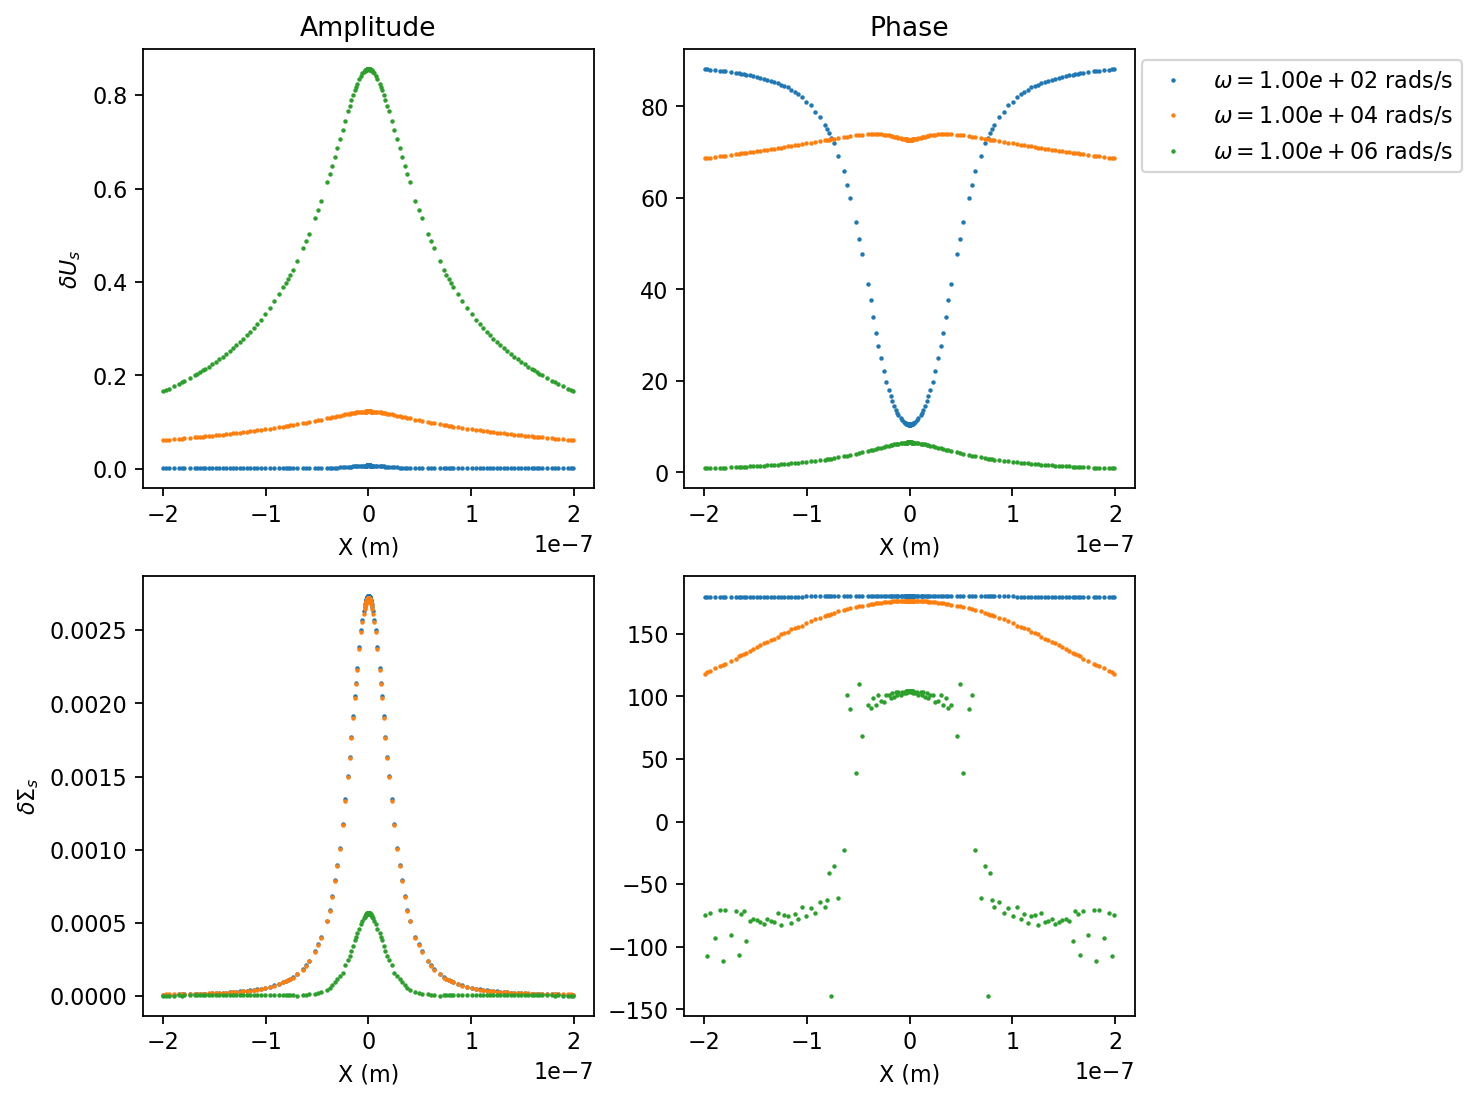

Done


In [46]:
def display_results_amp_phase():
    #savedir='/shared/zhuy359/sip/slab_1'
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=160)
    axs=ax.flatten()
    
    nodes=mesh['nodes']    
    mask=(nodes[:,1]==0)&(np.abs(nodes[:,0])<200e-9)
    labels=[]
    for i in [8,12,16]:
        unod=np.load(savedir+'/freq_%.2e.npy'%freqs[i])
        xp=np.r_[-nodes[mask,0],nodes[mask,0]]
        yp=np.r_[unod[mask,0],unod[mask,0]]
        axs[0].plot(xp,np.abs(yp),'.',markersize=2)
        axs[1].plot(xp,np.angle(yp)*180/np.pi,'.',markersize=2)
        
        xp=np.r_[-nodes[mask,0],nodes[mask,0]]
        yp=np.r_[unod[mask,1],unod[mask,1]]
        axs[2].plot(xp,np.abs(yp),'.',markersize=2)
        axs[3].plot(xp,np.angle(yp)*180/np.pi,'.',markersize=2)

        labels.append('$\omega=%.2e$ rads/s'%(freqs[i]))
        #axs[0].set_yscale('Log')
        #axs[2].set_yscale('Log')

    axs[0].set_title('Amplitude')
    axs[1].set_title('Phase')
    
    axs[0].set_ylabel('$\delta U_s$')
    axs[2].set_ylabel('$\delta \Sigma_s$')

    axs[0].set_xlabel('X (m)')
    axs[1].set_xlabel('X (m)')    
    axs[2].set_xlabel('X (m)')
    axs[3].set_xlabel('X (m)')
    axs[1].legend(labels,loc='upper right',bbox_to_anchor=(1.750,1.0))

    #plt.savefig('slab.png',bbox_inches='tight')
    return fig,ax

def display_results_real_imag():
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=160)
    axs=ax.flatten()
    
    nodes=mesh['nodes']    
    mask=(nodes[:,1]==0)&(np.abs(nodes[:,0])<200e-9)
    labels=[]
    for i in range(0,len(freqs),1):
        unod=np.load(savedir+'/freq_%.2e.npy'%freqs[i])
        xp=np.r_[-nodes[mask,0],nodes[mask,0]]
        yp=np.r_[unod[mask,0],unod[mask,0]]
        axs[0].plot(xp,np.real(yp),'.',markersize=2)
        axs[1].plot(xp,np.imag(yp)*180/np.pi,'.',markersize=2)
        
        xp=np.r_[-nodes[mask,0],nodes[mask,0]]
        yp=np.r_[unod[mask,1],unod[mask,1]]
        axs[2].plot(xp,np.real(yp),'.',markersize=2)
        axs[3].plot(xp,np.imag(yp)*180/np.pi,'.',markersize=2)

        labels.append('$\omega=%.2e$ rads/s'%(freqs[i]))
        #axs[0].set_yscale('Log')
        #axs[2].set_yscale('Log')

    axs[0].set_title('Real')
    axs[1].set_title('Imag')
    
    axs[0].set_ylabel('$\delta U_s$')
    axs[2].set_ylabel('$\delta \Sigma_s$')

    axs[0].set_xlabel('X (m)')
    axs[1].set_xlabel('X (m)')    
    axs[2].set_xlabel('X (m)')
    axs[3].set_xlabel('X (m)')
    axs[1].legend(labels,loc='upper right',bbox_to_anchor=(1.750,1.0))

    #plt.savefig('slab.png',bbox_inches='tight')
    return fig,ax

if __name__=='__main__':
    _,_=display_results_amp_phase()
    #_,_=display_results_real_imag()
    plt.show()
    print('Done')

## Inverse FFT <a id="4.8"></a>